#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **HistGradientBoostingRegressor**

*Autor*: **Jose Eduardo Cámara Gómez**

---

## Importar paquetes

In [1]:
# Importación de paquetes
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0,
                 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)
df["bajas"] = df["NumBajas"] / (df["NumAnimales"] * df["DiasMedios"])
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")

# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
# Cargamos las variables objetivo y las usadas (15 variables seleccionadas, una de ellas categórica con 8 valores).
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'NumAnimales', 'na_rega', 
         'PesoEntMedio', 'PesoRecMedio', 'bajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)

Saving gmd_02.csv to gmd_02.csv


In [3]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)
## Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [4]:
# Lanzamos el modelo con los parámetros por defecto
modelo = HistGradientBoostingRegressor(
            loss = "squared_error",
            learning_rate=0.1,
            max_iter=100,
            max_leaf_nodes=31,
            random_state = 123
         )
modelo.fit(X_train_s, y_train)

HistGradientBoostingRegressor(random_state=123)

Score R2: 0.8476511539323192


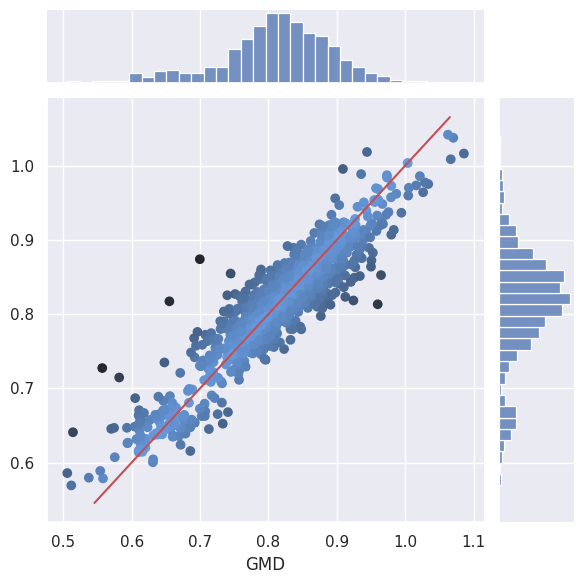

In [5]:
# Función para Graficar diferencias entre valor predicho y real en datos de test del modelo pasado
def graficoDiferencias(modelo, X_test_s, y_test):
    y_pred = modelo.predict(X_test_s)
    diferencia = abs(y_pred - y_test)
    g = sns.jointplot(x=y_test, y=y_pred)
    # Draw a line of x=y
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    g.ax_joint.scatter(x=y_test, y=y_pred, c=diferencia.values, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
    plt.show()

# Graficar las diferencias
print('Score R2:',modelo.score(X_test_s, y_test))
graficoDiferencias(modelo, X_test_s, y_test)

In [6]:
# Analizamos otros errores del método
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
y_pred = modelo.predict(X_test_s)
# Definimos la función con las métricas a mostrar
def mostrar_metricas(y_test, y_pred):
   print("Metr.\t Valor\t\t\t Descripción")
   print("R^2 \t", r2_score(y_test, y_pred), "\t (Coeficiente de Determinación)")
   print("RMSE\t", mean_squared_error(y_test, y_pred, squared=True), "\t (Raíz de error cuadrático medio)")
   print("MAE \t", mean_absolute_error(y_test, y_pred), "\t (Error absoluto medio)")
   print("MAX \t", max_error(y_test, y_pred), "\t (Error Máximo)")
# Pedimos que muestre las métricas para el modelo de RandomForest
print("Métricas para RandomForest v1")
mostrar_metricas(y_test, y_pred)

Métricas para RandomForest v1
Metr.	 Valor			 Descripción
R^2 	 0.8476511539323192 	 (Coeficiente de Determinación)
RMSE	 0.0010916783631631634 	 (Raíz de error cuadrático medio)
MAE 	 0.02515203975776052 	 (Error absoluto medio)
MAX 	 0.17427550398957703 	 (Error Máximo)


# Optimización de Hiperparámetros

In [7]:
# Hacemos una optimización de los hiperparámetros básica para RandomForest y vemos de probar de forma aleatoria con la combinación de 100 de estos modelos a ver cuál es el que mejor ajusta el MSRE.
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.5],
               'max_iter': [10, 30, 50, 100, 200, 500, 1000],
               'max_leaf_nodes': [5, 10, 20, 30, 50, 100, 200]}
modelo_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = modelo, 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=123, n_jobs = -1)
modelo_random.fit(X_train_s, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingRegressor(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.25, 0.3,
                                                          0.5],
                                        'max_iter': [10, 30, 50, 100, 200, 500,
                                                     1000],
                                        'max_leaf_nodes': [5, 10, 20, 30, 50,
                                                           100, 200]},
                   random_state=123, scoring='neg_mean_squared_error',
                   verbose=1)

In [9]:
modelo_random.best_params_

{'max_leaf_nodes': 5, 'max_iter': 1000, 'learning_rate': 0.1}

In [8]:
print("Estimadores para Train")
mostrar_metricas(y_train, modelo_random.best_estimator_.predict(X_train_s))
print("")
print("Estimadores para Test")
mostrar_metricas(y_test, modelo_random.best_estimator_.predict(X_test_s))


Estimadores para Train
Metr.	 Valor			 Descripción
R^2 	 0.9181345063853255 	 (Coeficiente de Determinación)
RMSE	 0.0005632649816280457 	 (Raíz de error cuadrático medio)
MAE 	 0.01841218605638466 	 (Error absoluto medio)
MAX 	 0.1369394846401235 	 (Error Máximo)

Estimadores para Test
Metr.	 Valor			 Descripción
R^2 	 0.8438046323594022 	 (Coeficiente de Determinación)
RMSE	 0.0011192411867944516 	 (Raíz de error cuadrático medio)
MAE 	 0.02530588487320156 	 (Error absoluto medio)
MAX 	 0.17435190880309026 	 (Error Máximo)


Como se puede apreciar el método parece mejorar en entrenamiento, pero es únicamente sobreajustándose al modelo, ya que si vemos el error en datos de test este no ha mejorado nada, más bien ha empeorado ligeramente.

Intentamos ahora hacerlo con early_stopping. Este modelo permite ser lanzado con la opción de early stopping, y es esta buscar optimizar no los resultados para train si no para test (reserva un porcentaje de los datos de entrenamiento para realizar la validación con datos no usados). Podemos ponerle un número de iteaciones máximas muy grande pues se espera que acabe antes el proceso por no mejorar según las condiciones de early stopping.


Binning 0.001 GB of training data: 0.022 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/50000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00293, val loss: 0.00315, in 0.021s
[2/50000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00253, val loss: 0.00277, in 0.011s
[3/50000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00220, val loss: 0.00247, in 0.010s
[4/50000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00194, val loss: 0.00222, in 0.011s
[5/50000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00172, val loss: 0.00200, in 0.013s
[6/50000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00154, val loss: 0.00183, in 0.011s
[7/50000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00139, val loss: 0.00168, in 0.012s
[8/50000] 1 tree, 31 leaves, max depth = 9, train loss: 0.00127, val loss: 0.00156, in 0.012s
[9/50000] 1 tree, 31 leaves, max depth = 8, train loss: 0.00116, val loss: 0.00146, in 0.012s
[10/50000] 1 tree, 31 leaves, max

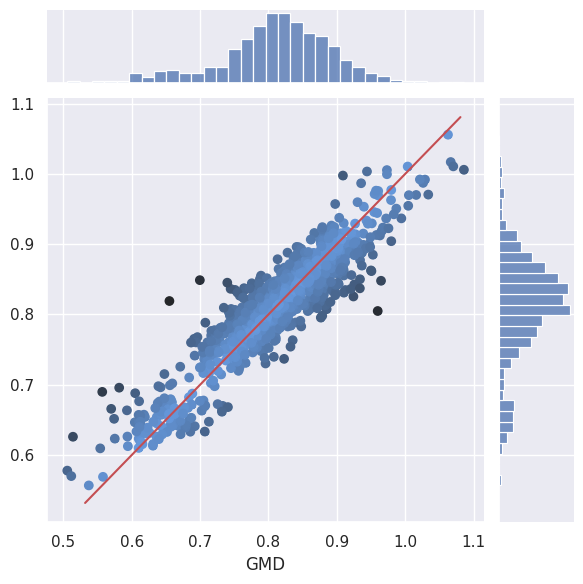

In [10]:
modelo2 = HistGradientBoostingRegressor(
            loss = "squared_error",
            learning_rate=0.1,
            max_iter=50000,
            max_leaf_nodes=31,
            early_stopping=True,
            scoring='loss', 
            validation_fraction=0.1, 
            n_iter_no_change=10, 
            tol=1e-07, 
            verbose=1,
            random_state = 123
         )
modelo2.fit(X_train_s, y_train)
# Mostramos los errores mediante este método
print("Estimadores para Train")
mostrar_metricas(y_train, modelo2.predict(X_train_s))
print("")
print("Estimadores para Test")
mostrar_metricas(y_test, modelo2.predict(X_test_s))
## Mostramos la gráfica del entrenamiento
graficoDiferencias(modelo2, X_test_s, y_test)

Como se aprecia de todas las iteraciones permitidas ha parado tras 95 por no estar ya mejorando el error en validación, que se había estancado en 0.00073, a pesar que el error en train ya había bajado a 0.00026.

Vemos de lanzar la búsqueda de los mejores hiperparametros usando este ñultimo modo con una búsqueda aleatoria de hiperparémtros, y mostrando la gráfica de entrenamiento. 

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Binning 0.001 GB of training data: 0.015 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00295, val loss: 0.00301, in 0.008s
[2/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00256, val loss: 0.00265, in 0.009s
[3/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00224, val loss: 0.00237, in 0.010s
[4/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00197, val loss: 0.00212, in 0.009s
[5/200] 1 tree, 20 leaves, max depth = 6, train loss: 0.00176, val loss: 0.00193, in 0.009s
[6/200] 1 tree, 20 leaves, max depth = 8, train loss: 0.00158, val loss: 0.00177, in 0.008s
[7/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00144, val loss: 0.00164, in 0.008s
[8/200] 1 tree, 20 leaves, max depth = 7, train loss: 0.00131, val loss: 0.00153, in 0.008s
[9/200] 1 tree, 20 leaves, max depth = 8, train loss: 0.00121, val loss: 0.00144

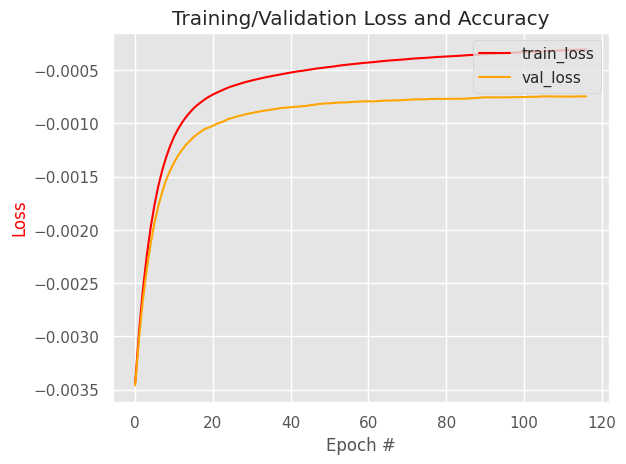

In [11]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.5, 1],
               'max_iter': [200, 500, 1000, 5000],
               'max_leaf_nodes': [5, 10, 20, 30, 50, 100, 200],
               'early_stopping': [True],
               'validation_fraction': [0.1, 0.15, 0.2],
               'n_iter_no_change': [10, 15],
               'tol': [1e-07]
               }
modelo_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = modelo2, 
                               param_distributions = random_grid, n_iter = 200, 
                               cv = 3, verbose=1, random_state=123, n_jobs = -1)
modelo_random.fit(X_train_s, y_train)

## Mostramos los resultados
print("Estimadores para Train")
mostrar_metricas(y_train, modelo_random.best_estimator_.predict(X_train_s))
print("")
print("Estimadores para Test")
mostrar_metricas(y_test, modelo_random.best_estimator_.predict(X_test_s))

## Mostramos la gráfica del entrenamiento
def mostrar_entrenamiento(modelo):
    # Muestro gráfica de accuracy y losses
    plt.style.use("ggplot")
    fig,ax = plt.subplots()
    filas = len(modelo.validation_score_)
    ax.plot(np.arange(0, filas), modelo.train_score_, label="train_loss", color="red")
    ax.plot(np.arange(0, filas), modelo.validation_score_, label="val_loss", color="orange")
    # Pongo en un eje secundario la Precisión, porque la escala no está en los mismos rangos
    #ax2=ax.twinx()
    #ax2.plot(np.arange(0, filas), H.history["accuracy"], label="train_acc", color="blue")
    #ax2.plot(np.arange(0, filas), H.history["val_accuracy"], label="val_acc", color="green")
    ax.set_title("Training/Validation Loss and Accuracy")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss", color="red")
    #ax.set_ylim(0., np.max(H.history["loss"]))
    #ax2.set_ylabel("Accuracy", color="blue")
    #ax2.set_ylim(0., 1.)
    ax.legend(loc="upper right")
    #ax2.legend(loc="lower right")
mostrar_entrenamiento(modelo_random.best_estimator_)

In [12]:
modelo_random.best_params_

{'validation_fraction': 0.15,
 'tol': 1e-07,
 'n_iter_no_change': 10,
 'max_leaf_nodes': 20,
 'max_iter': 200,
 'learning_rate': 0.1,
 'early_stopping': True}